# Dijkstra's Single Source Shortest Path Algorithm


Have you ever wondered the algorithm that powers finding the shortest route between two locations on Google Maps?
(or) How network packets are efficiently routed from the source node to the target node in a network?

The answers to the above questions can be found in the Single Source Shortest Path Algorithm, more commonly referred as the **Dijkstra's Algorithm**. In the context of networking, the notable routing algorithms that use the Dijkstra's algorithms are [Intermediate System to Intermediate System (IS-IS)](https://en.wikipedia.org/wiki/IS-IS) and [Open Shortest Path First (OSPF)](https://en.wikipedia.org/wiki/Open_Shortest_Path_First) both of which correspond to the class of routing algorithms called [Link State Routing(LSR)](https://en.wikipedia.org/wiki/Link-state_routing_protocol).



In this notebook, we aim to introduce the idea of implementing the Dijkstra's algorithm on a *undirected, weighted graph*. If the terms *undirected graphs* and *weighted graphs* are new to you, please check out the previous notebook [0_graphs and graph representations](#). This notebook is organized as follows:

### Table of Contents
1. [Building the graph](#setup1)
2. [Implementing Dijkstra shortest path algorithm](#algorithm)
    1. [Algorithm Steps](#steps1)
    2. [Pseudocode](#pseudocode1)
3. [Computing the shortest path given source and target nodes](#shortestPath1)
4. [Running Dijkstra on a weighted, directed graph](#directedGraphs)
5. [Proof of Correctness](#proof)
6. [Optimizing using adjacency list representation and priority queues](#optimization)
    1. [What are heaps?](#heaps)
    2. [How the current algorithm changes?](#pseudocode2)
7. [Running time comparison](#runningTime)
8. [References](#references)

## Fetching required modules

Before, we get started lets import code modules which would make us focus on understanding the Dijkstra's shortest path algorithm.

In [1]:
import os, sys
from os.path import dirname, join, abspath
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, abspath(join(dirname("modules"), '..')))
from modules.create_graph import *
from modules.visualize_graph import *

<a class="anchor" id="setup1"></a>
## Building the graph 

This is a sample graph that will be used by us for the entire notebook. You are free to add (or) change the number of nodes, and edges. Typically, both nodes and edges can contain information. For example in a typical home network the nodes represent the network components_that can be named like 'home router' (or) 'switch' and the edges represents the distance between the network components.In our implementation of creating a graph, you can also pass an additional data parameter which allows the nodes in the graphs to hold additional data. 

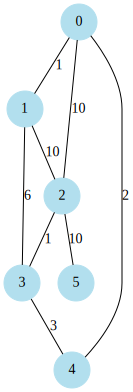

In [2]:
a = Node()
b = Node()
c = Node()
d = Node()
e = Node()
f = Node()
g = Node()

graphs = Graph.createGraph([a, b, c, d, e, f], directed=False)


graphs.add_Edge(a,b,1)
graphs.add_Edge(a,c,10)
graphs.add_Edge(a,e,2)
graphs.add_Edge(b,c,10)
graphs.add_Edge(b,d,6)
graphs.add_Edge(c,d,1)
graphs.add_Edge(c,f,10)
graphs.add_Edge(d,e,3)


visualizeGraph(graphs, "Dijkstra")

<a class="anchor" id="algorithm"></a>
## Implementing Dijkstra's shortest path algorithm

### About the algorithm
The idea behind Dijkstra's algorithm is to find the shortest path from a source Node to all the nodes (or) a specific target node on the graph without checking every source-to-destination combination, which in the worst case could be exponential in the number of vertices. Thus, considering every source-to-destination combination means that the computation of shortest path in large graphs becomes time consuming and cumbersome. Dijkstra's algorithm proposes a greedy approach, where at every iteration, the algorithm chooses a vertex with the current shortest distance and searches for paths extending from that vertex. We will make these statements clearer in coming sections.

<a class="anchor" id="steps1"></a>
### Algorithm steps

**Setup()**
1. Set distance to all node nodes from the `source` as `infinity`. Set distance of source to itself as zero.
2. Initialise two sets; `seen` and `unseen`, with `seen` being an empty set and `unseen` being the set of all vertices. 
3. Set the `previous` attribute of every node as undefined.

**Loop()**
4. **While** there exists a node in the queue that is not `seen`:
5. Set the `current min node` as the node in `unseeen` with the smallest distance (in code, referred as `min_node` and `min_dist`). In the first iteration of the loop, this will be the source node and thus we set the `dist` as 0.
6. Add the `current min node` to the `seen` set.
7. For every neighbour of  `current min node` in `unseen` do the following: if the sum of distance of `current min node` and the length from `current min node` to the neighbour under consideration is less than it's current distance, update it's distance to the currently computed smaller distance. Further, update the `previous` attribute of the node to `current min node`.
8. **End While**

<a class="anchor" id="pseudocode1"></a>
### Pseudo Code
<pre> 
1  <b>function</b> Dijkstra(<i>Graph</i>, <i>source</i>):
2     create node set 
3      create node set Q
4
5      <b>for each</b> node <i>v</i> in <i>Graph</i>:             
6          dist[<i>v</i>] ← INFINITY                  
7          prev[<i>v</i>] ← UNDEFINED                 
8          add <i>v</i> to <i>Q</i>                      
10      dist[<i>source</i>] ← 0                        
11      
12      <b>while</b> <i>Q</i> is not empty:
13          <i>u</i> ← node in <i>Q</i> with min dist[u]    
14                                              
15          remove <i>u</i> from <i>Q</i> 
16          
17          <b>for each</b> neighbor <i>v</i> of <i>u</i> in <i>Q</i>:           <i>// only v that are still in Q</i>
18              <i>alt</i> ← dist[<i>u</i>] + length(<i>u</i>, <i>v</i>)
19              <b>if</b> <i>alt</i> &lt; dist[<i>v</i>]:               
20                  dist[<i>v</i>] ← <i>alt</i> 
21                  prev[<i>v</i>] ← <i>u</i> 
22
23      <b>return</b> dist[], prev[]
</pre>

In [3]:
def dijkstra(graph, sourceNode, targetNode):
    sourceNodeIndex = graph.get_nodeIndex(sourceNode)
    targetNodeIndex = graph.get_nodeIndex(targetNode)
    nodeList = graph.get_allNodes()

    # Make an array keeping track of distance from node to any node
    # in self.nodes. Initialize to infinity for all nodes but the 
    # starting node, keep track of "path" which relates to distance.
    # Index 0 = distance, index 1 = previous_hops
    dist = [None] * len(nodeList)
    previous = [None] * len(nodeList)
    for i in range(len(dist)):
        dist[i] = float("inf")
        previous[i] = [sourceNodeIndex]

    
    dist[sourceNodeIndex] = 0
 
    # Queue of all nodes in the graph
    # Note the integers in the queue correspond to indices of node
    # locations in the self.nodes array
    queue = [i for i in range(len(nodeList))]
    
    # Set of numbers seen so far
    seen = set()
    while len(queue) > 0:
        # Get node in queue that has not yet been seen
        # that has smallest distance to starting node
        min_dist = float("inf")
        min_node = None
        for n in queue: 
            if dist[n] < min_dist and n not in seen:
                min_dist = dist[n]
                min_node = n
        try:
            # Add min distance node to seen, remove from queue
            queue.remove(min_node)
            seen.add(min_node)


            # Get all next hops -> all shortest paths
            connections = graph.get_connections(min_node)

            # For each connection, update its path and total distance from 
            # starting node if the total distance is less than the current distance
            # in dist array
            print("current node %s" % min_node)
            print ("neighbors:" , [node for (node, weight) in connections.items()])
            for (node, weight) in connections.items(): 
                print(node, weight)
                tot_dist = weight + min_dist
                print("From Node %s to Node %s there is an edge of weight %d" % (min_node, node, weight))
                print('Previous distance value: %.0f' % dist[node])
                print('Computed distance value: %d' % tot_dist)
                if tot_dist < dist[node]:
                    #if less, print the update
                    print("Initial Distance was %.0f has been updated to %d " % (dist[node], tot_dist))
                    dist[node] = tot_dist
                    previous[node] = list(previous[min_node])
                    previous[node].append(node)
                    
                    if node != targetNodeIndex :
                        print("Distance not updated, previous distance of %.0f is retained" % dist[node])
                    else:
                        print("\n****************************************************************************************")
                        print("Total distance to sourceNode %d from targetNode %d is %d" % (sourceNodeIndex, targetNodeIndex, dist[node]))
                        print("Nodes part of the shortest path: ", previous[node])
                        return dist[node], previous[node]
        except ValueError:
                print ("Distance to node %d is %d" %(targetNodeIndex, sys.maxsize))
                return None, None
                
        print("---------------------------------------------------------------------------------------\n")
    

<a class="anchor" id="shortestPath1"></a>
## Computing the shortest path given source and target nodes

Now, that we have an understanding of how DIjkstra's algorithm computes the shortest path, we find the shortest path between a given source node and the target node. In short, we visualize only the shortest path between the source and the target nodes instead of visualizing the shortest paths to all the nodes. 

current node 0
neighbors: [1, 2, 4]
1 1
From Node 0 to Node 1 there is an edge of weight 1
Previous distance value: inf
Computed distance value: 1
Initial Distance was inf has been updated to 1 
Distance not updated, previous distance of 1 is retained
2 10
From Node 0 to Node 2 there is an edge of weight 10
Previous distance value: inf
Computed distance value: 10
Initial Distance was inf has been updated to 10 
Distance not updated, previous distance of 10 is retained
4 2
From Node 0 to Node 4 there is an edge of weight 2
Previous distance value: inf
Computed distance value: 2
Initial Distance was inf has been updated to 2 
Distance not updated, previous distance of 2 is retained
---------------------------------------------------------------------------------------

current node 1
neighbors: [0, 2, 3]
0 1
From Node 1 to Node 0 there is an edge of weight 1
Previous distance value: 0
Computed distance value: 2
2 10
From Node 1 to Node 2 there is an edge of weight 10
Previous distance va

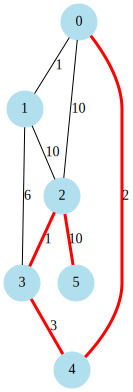

In [4]:
sourceNode = a
targetNode = f

distances, previousNodes = dijkstra(graphs, sourceNode, targetNode)
edgelist = []
path = None
if previousNodes != None:
    for i in range(len(previousNodes)):
            try:
                wt = graphs.get_edgeWeight(previousNodes[i],previousNodes[i+1])
                edgelist.append((previousNodes[i],previousNodes[i+1], wt))

            except IndexError:
                break

    path = displayPath(edgelist, "Dijkstra")
else:
    print(distances)

path

<a class="anchor" id="directedGraphs"></a>
## Running Dijkstra on a weighted, directed graph

To establish that the Dijkstra's algorithm could be run on directed graphs, we convert our previous graph into a weighted, directed graph by adding a few other edges to account for one-direction communication between two nodes

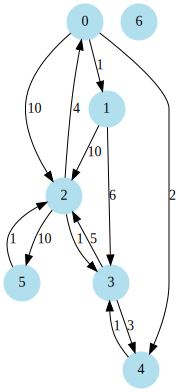

In [5]:
directed_graphs = Graph.createGraph([a, b, c, d, e, f, g], directed=True)


directed_graphs.add_Edge(a,b,1)
directed_graphs.add_Edge(a,c,10)
directed_graphs.add_Edge(c,a,4)
directed_graphs.add_Edge(a,e,2)
directed_graphs.add_Edge(b,c,10)
directed_graphs.add_Edge(b,d,6)
directed_graphs.add_Edge(d,c,5)
directed_graphs.add_Edge(c,d,1)
directed_graphs.add_Edge(f,c,1)
directed_graphs.add_Edge(c,f,10)
directed_graphs.add_Edge(d,e,3)
directed_graphs.add_Edge(e,d,1)

visualizeGraph(directed_graphs, "directedDijkstra")


current node 0
neighbors: [1, 2, 4]
1 1
From Node 0 to Node 1 there is an edge of weight 1
Previous distance value: inf
Computed distance value: 1
Initial Distance was inf has been updated to 1 
Distance not updated, previous distance of 1 is retained
2 10
From Node 0 to Node 2 there is an edge of weight 10
Previous distance value: inf
Computed distance value: 10
Initial Distance was inf has been updated to 10 
Distance not updated, previous distance of 10 is retained
4 2
From Node 0 to Node 4 there is an edge of weight 2
Previous distance value: inf
Computed distance value: 2
Initial Distance was inf has been updated to 2 
Distance not updated, previous distance of 2 is retained
---------------------------------------------------------------------------------------

current node 1
neighbors: [0, 2, 3]
0 1
From Node 1 to Node 0 there is an edge of weight 1
Previous distance value: 0
Computed distance value: 2
2 10
From Node 1 to Node 2 there is an edge of weight 10
Previous distance va

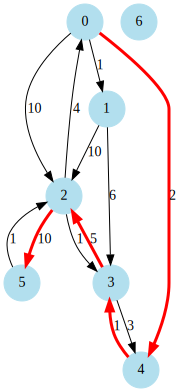

In [6]:
sourceNode = a
targetNode = f

dir_distances, dir_previousNodes = dijkstra(directed_graphs, sourceNode, targetNode)

dir_edgelist = []
if dir_previousNodes == None:
    print(dir_distances)
else:
    for i in range(len(dir_previousNodes)):
                try:
                    wt = directed_graphs.get_edgeWeight(dir_previousNodes[i],dir_previousNodes[i+1])
                    dir_edgelist.append((dir_previousNodes[i],dir_previousNodes[i+1], wt))

                except IndexError:
                    break

displayPath(dir_edgelist, "directedDijkstra")



In [7]:
dir_edgelist

[(0, 4, 2), (4, 3, 1), (3, 2, 5), (2, 5, 10)]

<a class="anchor" id="proof"></a>
## Proof of Correctness

We will now formally prove the correctness of Dijkstra's algorithm. 

Let us first setup some required notation. Consider Dijkstra's algorithm run on a directed, weighted graph represented as $G(V,E)$ where $V$ is the set of nodes of $G$ and E is the set of edges of $G$ which contain non-negative edges. Let $s$ denote the source node. For any node $u \in V$, let $\delta(u)$ denote the shortest path distance between node $s$ to node $u$. Let $d[u]$ denote the distance computed by Dijkstra's algorithm from source node $s$ to node $u$.

To prove the correctness of Dijkstra's algorithm, we need to establish that $$d[u] = \delta(u) \quad  \forall u \in V.$$ We will show that the above equality is true at the moment when node $u$ is added to the set of visited nodes $S$. At any iteration, let $Q$ denote the set of not visited nodes, such that $V = S \cup Q$. Once we establish the above equality at the moment of addition of node $u$ to $S$, we make use of the fact that the distance is not updated thereafter for node $u$ to establish the correctess at further time instances.

*Initialization:* We set $d[s] = 0$ and set all other distances as infinity, i.e., $d[u] = \infty \quad \forall u \in V, u \neq s$.

*Induction hypothesis or assumption*: For all nodes $x$ in visited set $S$, $d[x] = \delta(x).$

After the first iteration, $S = \{s\}$ and $d[s] = \delta(s) = 0$, thus satisfying the induction hypothesis.

*Induction step:* We show that for a new node $u$ added to visited set $S$, $d[u] = \delta(u).$ We will prove this claim via contradiction. 

**Claim 1:** For all nodes $v$ not in set of visited nodes, $d[v] \ge \delta(v).$

*Proof:* If $d[v] = \infty,$ the claim is trivially true. If $d[v] < \infty,$ there exists $x \in S$ such that 
\begin{align}
d[v] &= d[x] + len(x,v)\\
&=\delta(x)+len(x,v)\\
&\ge \delta(v),
\end{align}
where the second equality follows from our inductive hypothesis on the set of visited nodes $S$, and the third inequality follows from the fact that this is the distance for one feasible path and does not necessarily be the optimal path to $v$.

Let $u$ be the first node for which $d[u] \neq \delta(u)$ when it is added to the set of visited nodes $S$. Combined with the above claim, this implies that $d[u] > \delta(u)$. Let $P$ denote the optimal path from source $s$ to $u$ with distance $\delta(u)$. Let the path $P$ be represented as $P = s-x^*-y-u$, where $x^*$ is the last element of $P$ in $S$, and let $y \in Q$ be the first element just after $x^*$. The following inequalities should hold:
\begin{align}
\delta(u) &= \delta(x^*)+len(x^*,y)+length(y,u)\\
&\ge d[y] + length(y,u)\\
&\ge d[y]\\
&\ge d[u],
\end{align}

which contradicts the initial claim. The first inequality holds from the definition of $d[y]$, the second inequality follows as $length(y,x) \ge 0$, and the third inequality follows from the fact that since $u$ was chosen over $y$ to be added to $S$, $d[u] \le d[y]$. 

Hence, $d[u] = \delta(u)$.

## Running Dijkstra's on Negative-weighted graphs

--algorithm does not guarantee shortest path, and the reason for the same; bellman-Ford works--

<a class="anchor" id="runningTime"></a>
## Running Time comparison

The running time of the Dijkstra's algorithm is computed with respect to the number of nodes (|V|) and number of edges (|E|) on the graph. However, the perforamnce or running time of the Dijkstra's algorithm is determined by the data strucutre that is used to implement the set of unvisited nodes. The upper bound of the Dijkstra's algorithm can be simply approximated as $O(|V|^2)$, however, this approximation is an over-simplified expression.

Depending on the implementation of the set of univisited nodes, the running time expression for the Dijkstra's algorithm can be $O(|E|\cdot T_{\mathrm {dk} }+|V|\cdot T_{\mathrm {em} })$ where $T_{\mathrm {dk}}$ represents the time complexity of removing the current seen node and $T_{\mathrm {em}}$ represents the time complexity for removing the node which has the minimum distance. 

While using the adjacency matrix representation, the time complexity for removing the node with the minimum distance can be defined as the time taken to perform a linear search across all the unvisited nodes, and so, the running time is represented as $O(|E|+|V|^2) = O(|V|^2)$. For a dense graph that is represented as an adjacency list, the running time can be represented as $O((|V|^2) log(V))$

When the graph is sparse i.e. the graph has fewer than $|V|^2$ edges, Dijkstra's algorithm can be implemented efficiently using adjacency lists for representing the graph and min-heaps for extracting the nodes with minimum distance in each iteration. In our implementaiton, the min-heap is implemented using the [`heapq package`](https://docs.python.org/3.6/library/heapq.html) which takes $O(log(E))$ to pop (or) remove the node with minimum distance from the heap and it takes $O((|V|) log(V))$ to build the heap. Thus, the total running time for the implementation with the `heapq pacakge` is $O((|E| + |V|) log(V))$.

**Note**: It is possible to improve the efficiency of the algorithm using [Fibonacci heaps](https://en.wikipedia.org/wiki/Fibonacci_heap) and [Binary Heaps](https://en.wikipedia.org/wiki/Binary_heap) which are not discussed in this notebook. It is also recommended to refer the [A* algorithm](https://en.wikipedia.org/wiki/A*_search_algorithm) 

## Summary of running time
|                | Adjacency Matrix | Adjacency Lists | Priority Queue | Binary Min Heap | Fibonacci Heap |
|----------------|------------------|-----------------|----------------|-----------------|----------------|
| Extracting Min |                  |                 |                |                 |                |
|                |                  |                 |                |                 |                |
|                |                  |                 |                |                 |                |

<a class="anchor" id="optimization"></a>
## Optimizing using adjacency list representation and priority queues

Now that we have clear distinction that adjacency list representation offers a better algorithmic performance over adjacency matrix. We would like to see if we could optimize the algorithmic performance of our implementation of the Dijkstra's Shortest Path algorithm.

### Why optimize?
Dijkstra's shortest path is already a greedy algorithm which saves computation and time, since in every iteration of the algorithm, we find the node with smallest distance before making our next greedy decision. This decision-making step ensures that not every possible source-destination combination is checked in order to determine the shortest path.

In our implementation of the Dijkstra's algorithm, so far, we search through a list, `queue` based on the values of `dist`. The maximum length of `queue` is the number of nodes$(n)$ in the graph, therefore iterating along the `queue` takes $O(n)$ time. Since, we terminate only when all the nodes are visited, that is the length of `seen` set is the number of nodes in the graph, we are doing the $O(n)$ operation of iterating through the nodes n-times, making the total running time of our implementation to become $O(n^2)$. Now, if we look at our graph representation, we use an adjacency matrix, which means to find the connections (or) the edges for a particular node, we iterate through the entire matrix row which has the length equal to the number of nodes in the graph. This adds another $O(n)$ time while iteration while looping through each node in the graph.


### Optimization Steps
1. Instead of iterating through the entire row of the adjacency matrix representation of the graph to find the nodes adjacent to the current node at $O(n)$ time, we use the adjacency list representation which could reduce the time to find adjacent nodes to $O(k)$ where `k` refers to the number of edges for the node.
2. Instead of maintaining a list of nodes and iterating over them at $O(n)$ time, we can use a [Binary Heap](https://medium.com/cantors-paradise/dijkstras-shortest-path-algorithm-in-python-d955744c7064)
 which helps to find the node with the minimum distance at $O(log(n))$ or use a [Fibonacci Heap](https://ieeexplore.ieee.org/document/715934) which will make the task to find the nodes with minimum distance at $O(1)$ time.

<a class="anchor" id="heaps"></a>
### What are Heaps?
Heaps are binary trees where every parent node has a value less than or equal to any of its children. In other words, this type of queue keeps track of the minimum value. Thus it helps retrieve the minimum value at all times. For this reason, it is also referred to as min heap. Thus, position 0 holds the smallest/minimum value. There is also a max heap whose operation is quite similar.

**Note:** heap queues or priority queues don’t sort lists in ascending order. It just keeps the smallest element in its 0th position. The rest of the elements may or may not be sorted.[1](https://www.pythoncentral.io/priority-queue-beginners-guide/).

In this notebook, we shall only look at heaps as efficient data strucutres to build priority queues, but you can read more about heaps on these articles from [tutorialspoint.com](https://www.tutorialspoint.com/data_structures_algorithms/heap_data_structure.htm) and [hackerearth.com](https://www.hackerearth.com/practice/data-structures/trees/heapspriority-queues/tutorial/) to get some more insights on the heap data structure.

<a class="anchor" id="pseudocode2"></a>
### How the current algorithm changes?
**Using Priority Queues:** Now, we are using heaps to implement priority queues because heaps effficiently handle situations of removing the node with the highest priority. In the context of Dijkstra's algorithm, the highest priority is the smallest distance computed to visit the remaining unvisited nodes. Instead of iterating over a list to find the node with minimum distance, we use the heap where the node with the minimum distance is already ready. After removing this node from the heap, the heap re-arranges itself based on the "heap property". 

**Updated Pseudocode:**
Dijkstra's algorithm is optimized by using a min-priority queue. The reason for selecing a min-priority queue is because, the greedy condition of the algorithm selects the edge with the minimum distance. 

<pre>1  <b>function</b> Dijkstra(<i>Graph</i>, <i>source</i>):
2    dist[<i>source</i>] ← 0 <i>// Initialization</i>
3    create node priority queue Q
4
5   <b>for each</b> node <i>v</i> in <i>Graph</i>:           
6       <b>if</b> <i>v</i> ≠ <i>source</i>
7           dist[<i>v</i>] ← INFINITY <i>// Unknown distance from source to v</i>
8       prev[<i>v</i>] ← UNDEFINED <i>// Predecessor of v</i>
9
10      <i>Q</i>.add_with_priority(<i>v</i>, dist[<i>v</i>])
11
12   <b>while</b> <i>Q</i> is not empty: <i>// The main loop</i>
13         <i>u</i> ← <i>Q</i>.extract_min() <i>// Remove and return best node</i>
14         <b>for each</b> neighbor <i>v</i> of <i>u</i>: <i>// only v that are still in Q</i>
15             <i>alt</i> ← dist[<i>u</i>] + length(<i>u</i>, <i>v</i>) 
16             <b>if</b> <i>alt</i> &lt; dist[<i>v</i>]
17                 dist[<i>v</i>] ← <i>alt</i>
18                 prev[<i>v</i>] ← <i>u</i>
19                 <i>Q</i>.decrease_priority(<i>v</i>, <i>alt</i>)
20
21     <b>return</b> dist, prev
</pre>

In [8]:
from heapq import heapify, heappush, heappop

def makePath(node, path):
    if node.previous:
        path.append(node.previous.index)
        makePath(node.previous, path)  

    return path


def dijkstraHeap(graph, source, target):

    nodeList = graph.get_allNodes()
    graph.set_distance(source, 0)

    sourceIndex = graph.get_nodeIndex(source)
    targetIndex = graph.get_nodeIndex(target)

    distance = {sourceIndex: 0}
    queue = [(distance[sourceIndex], sourceIndex)]
    heapify(queue)

    path = []
    path.append(targetIndex)

    while(queue):
        try:
            (minDistance, minIndex) = heappop(queue)
            if minIndex == targetIndex: 
                break


            for (nextIndex, weight) in graph.get_connections(nodeList[minIndex]).items():
                if (nextIndex not in distance) or ((minDistance + weight) < distance[nextIndex]):
                    distance[nextIndex] = minDistance + weight
                    graph.set_distance(nodeList[nextIndex], minDistance + weight)
                    graph.set_previous(nodeList[nextIndex], nodeList[minIndex])
                    heappush(queue, (nodeList[nextIndex].distance, nodeList[nextIndex].index))  
        except ValueError:
            break
            
    shortestPathNodes = makePath(target, path)
    shortestPathEdges = []

    for i in range(len(shortestPathNodes)):
        try:
            weight = graph.get_edgeWeight(shortestPathNodes[i], shortestPathNodes[i+1])
            shortestPathEdges.append([shortestPathNodes[i], shortestPathNodes[i+1], weight])
        except IndexError:
            break

    return(shortestPathNodes, shortestPathEdges, distance)

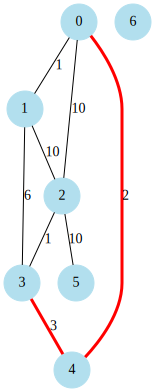

In [9]:
graphs = Graph.createGraph([a, b, c, d, e, f, g], directed=False)


graphs.add_Edge(a,b,1)
graphs.add_Edge(a,c,10)
graphs.add_Edge(a,e,2)
graphs.add_Edge(b,c,10)
graphs.add_Edge(b,d,6)
graphs.add_Edge(c,d,1)
graphs.add_Edge(c,f,10)
graphs.add_Edge(d,e,3)

visualDiGraph = visualizeGraph(graphs, "heapDijkstra")


shortestPathNodes, shortestPathEdges, distance = dijkstraHeap(graphs, a, d)
if shortestPathEdges is not None:
    path = displayPath(shortestPathEdges, "heapDijkstra")
else:
    print(distance)
    
path

<a class="anchor" id="references"></a>
## Reference

- [1] Leiserson, Charles Eric, Ronald L. Rivest, Thomas H. Cormen, and Clifford Stein. Introduction to algorithms. Chapter 24. Vol. 6. Cambridge, MA: MIT press, 2001.
- [2] Dijkstra's Algorithm on [Wikipedia](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm)
- [3] Micha Shute, Dijkstra's Shortest Path Algorithm in Python on [Medium](https://medium.com/cantors-paradise/dijkstras-shortest-path-algorithm-in-python-d955744c7064)